
[Cliente 9] Inicializado...

[Cliente 9] Carregando dados do smartwatch...

[Cliente 9] Aplicando filtro passa-baixa Butterworth para remover ruído de alta frequência dos sinais PPG...

[Cliente 9] Extraindo features HRV...

[Cliente 9] Definindo rótulo de anormalidade cardíaca...

[Cliente 9] Normalizando as features...

[Info] Separando dados em treino (60%), validação (20%) e teste (20%)...

[Info] Aplicando SMOTE apenas no conjunto de treino...
[Info] Após SMOTE - Classe 0: 115, Classe 1: 115

[Cliente 9] Aguardando modelo inicial do servidor...
[Cliente 9] Hiperparâmetros recebidos: {'loss': 'hinge', 'penalty': 'elasticnet', 'l1_ratio': 0.05, 'max_iter': 1, 'learning_rate': 'optimal', 'eta0': 0.005, 'alpha': 0.001, 'average': True, 'random_state': 42}
[Cliente 9] Modelo inicial recebido com sucesso!

[Cliente 9] Rodada 1 - Treinando modelo local com 230 exemplos...

=== Avaliação do Modelo Local treinado com dados locais rodada 1 ===
              precision    recall  f1-score   

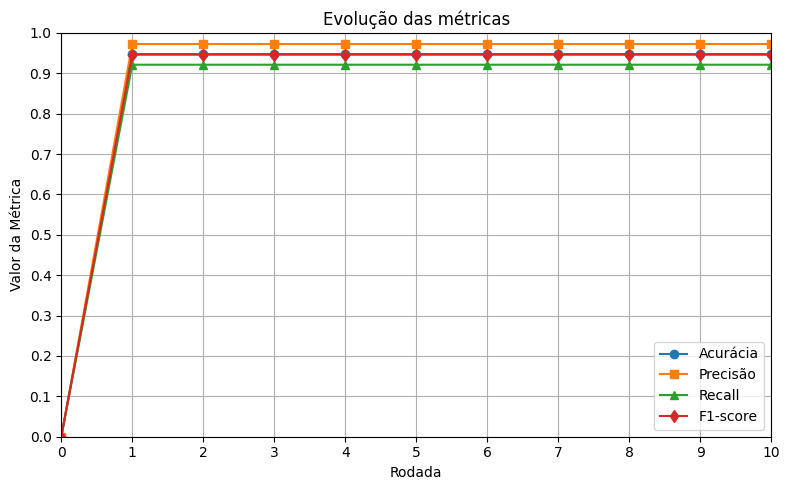

[Cliente 9] Enviando f1 por rodada para o servidor...
[Cliente 9] Parâmetros enviados!

[Cliente 9] Enviando métricas de desempenho do modelo local final ao servidor do hospital...
[Cliente 9] Métricas enviadas com sucesso!


In [1]:
import socket
import json
import time
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

SERVER_HOST = 'localhost'
SERVER_PORT_SEND = 5105  # Porta para enviar o modelo local para o servidor
SERVER_PORT_RECV = 5104  # Porta para receber o modelo intermediário do servidor

CLIENT_ID = 9            # Identificador do cliente (para simulação com múltiplos clientes)

# Carregar e preparar os dados
print(f"\n[Cliente {CLIENT_ID}] Inicializado...")

print(f"\n[Cliente {CLIENT_ID}] Carregando dados do smartwatch...")

ppg_csv = 'C:\\Users\\ferna\\Documents\\Unisinos\\Cadeiras\\TCC 2\\Dataset utilizado\\GalaxyPPG\\Dataset\\P20\\GalaxyWatch\\PPG.csv'

df_ppg = pd.read_csv(ppg_csv)
ppg_signal = df_ppg['ppg'].values            # Extrai o sinal PPG (fotopletismografia)
ppg_ts = df_ppg['timestamp'].values          # Extrai os timestamps (não usado diretamente)
fs = 25  # Frequência de amostragem do sinal (25 Hz)

# Filtragem do sinal PPG
print(f"\n[Cliente {CLIENT_ID}] Aplicando filtro passa-baixa Butterworth para remover ruído de alta frequência dos sinais PPG...")

def butter_lowpass(data, cutoff=5, fs=25, order=3):
    nyq = 0.5 * fs  # Frequência de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)  # Filtro passa-baixa aplicado em modo zero-phase (sem atraso)
    return y

ppg_filtered = butter_lowpass(ppg_signal, cutoff=5, fs=fs, order=3)

# Função para extrair features HRV a partir dos picos detectados
def extract_hrv_features_from_peaks(peaks, fs):
    try:
        if len(peaks) < 3:
            raise ValueError("Poucos picos detectados para análise HRV")

        # Calcula os intervalos entre batimentos (IBI) em segundos
        ibis = np.diff(peaks) / fs
        ibis_ms = ibis * 1000  # Converte para milissegundos

        # Cálculo das métricas HRV
        rmssd = np.sqrt(np.mean(np.square(np.diff(ibis_ms))))       # Raiz da média dos quadrados das diferenças consecutivas
        sdnn = np.std(ibis_ms)                                       # Desvio padrão dos intervalos
        pnn50 = np.sum(np.abs(np.diff(ibis_ms)) > 50) / len(ibis_ms) # Proporção de diferenças maiores que 50ms
        mean_ibi = np.mean(ibis_ms)                                  # Média dos intervalos
        iqr_ibi = np.percentile(ibis_ms, 75) - np.percentile(ibis_ms, 25)  # Intervalo interquartil

        return [rmssd, sdnn, pnn50, mean_ibi, iqr_ibi]
    except Exception as e:
        print(f"Erro no cálculo HRV: {e}")
        return [np.nan] * 5

# Função para encontrar o melhor threshold
def find_best_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = f1_scores.argmax()
    return thresholds[best_idx], f1_scores[best_idx]

# Extração das features com janela móvel
window_size = 30 * fs  # Janela de 30 segundos
step_size = 10 * fs    # Passo de 10 segundos (sobreposição de 20 segundos)

features = []
labels = []

print(f"\n[Cliente {CLIENT_ID}] Extraindo features HRV...")

print(f"\n[Cliente {CLIENT_ID}] Definindo rótulo de anormalidade cardíaca...")

for start in range(0, len(ppg_filtered) - window_size, step_size):
    segment = ppg_filtered[start:start + window_size]

    # Detecta picos no segmento com distância mínima de 0.5s entre eles (ajustável)
    peaks, _ = find_peaks(segment, distance=int(fs * 0.5))

    # Ignora segmentos com poucos picos detectados (não confiável para análise)
    if len(peaks) < 3:
        continue

    # Extrai as métricas HRV a partir dos picos detectados 
    hrv = extract_hrv_features_from_peaks(peaks, fs)

    # Ignora segmentos com métricas inválidas (NaN)
    if np.any(np.isnan(hrv)):
        continue

    rmssd, sdnn = hrv[0], hrv[1]

    # Define o label binário (0 = normal, 1 = possível anormalidade)
    label = int((rmssd < 20) or (sdnn < 50))

    features.append(hrv)
    labels.append(label)

# Converte listas para arrays NumPy
X = np.array(features)
y = np.array(labels)

# Normalização e divisão treino-teste
print(f"\n[Cliente {CLIENT_ID}] Normalizando as features...")
scaler = StandardScaler()
Xs = scaler.fit_transform(X)  # Normaliza as features para média 0 e desvio padrão 1

print(f"\n[Info] Separando dados em treino (60%), validação (20%) e teste (20%)...")

#1º split: separa 60% treino e 40% "val+test"
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs, y, test_size=0.4, random_state=42, stratify=y)

# Tamanho dos dados de treino antes do SMOTE
# Usado para ponderar a média federada
original_size = len(y_train)

# 2º split: divide os 40% restantes em 20% validação e 20% teste
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

print(f"\n[Info] Aplicando SMOTE apenas no conjunto de treino...")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"[Info] Após SMOTE - Classe 0: {sum(y_train == 0)}, Classe 1: {sum(y_train == 1)}")

# Obtendo o modelo inicial do servidor
print(f"\n[Cliente {CLIENT_ID}] Aguardando modelo inicial do servidor...")

while True:
    try:
        s = socket.create_connection((SERVER_HOST, SERVER_PORT_RECV), timeout=2)
        break
    except (ConnectionRefusedError, socket.timeout):
        time.sleep(1)

try:
    received_data = b""
    while True:
        chunk = s.recv(SERVER_PORT_RECV)
        if not chunk:
            break
        received_data += chunk

    decoded = json.loads(received_data.decode('utf-8'))
    global_coef = np.array(decoded['coef'])
    global_intercept = np.array(decoded['intercept'])
    global_params = decoded.get("params", {})
    
    NUM_ROUNDS = np.array(decoded['num_rounds']) 

    print(f"[Cliente {CLIENT_ID}] Hiperparâmetros recebidos: {global_params}")

    # Cria o modelo com os mesmos hiperparâmetros do server
    model = SGDClassifier(**global_params)

    # Dados fictícios para inicializar pesos
    X_fake = np.zeros((1, 5))      # Exemplo: 5 features
    y_fake = np.zeros(1)           # Intercepto inicial fixo

    # Chamada inicial para criar pesos e estruturas internas
    model.partial_fit(X_fake, y_fake, classes=[0, 1])
    
    # Substitui pelos valores do servidor
    model.coef_ = global_coef
    model.intercept_ = global_intercept
    
    print(f"[Cliente {CLIENT_ID}] Modelo inicial recebido com sucesso!")
except Exception as e:
    print(f"[Cliente {CLIENT_ID}] Erro ao receber modelo inicial: {e}")
finally:
    s.close()

# Treinamento do modelo de Regressão Logística
# Inicialização da lista de acurácia
accuracy_per_round = [0.0]  # Começa em 0
precision_per_round = [0.0]
recall_per_round = [0.0]
f1_per_round = [0.0] 

best_threshold_overall = 0.5  # valor default para o primeiro round
best_f1_overall = 0.0

# Laço de rodadas federadas
for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n[Cliente {CLIENT_ID}] Rodada {round_num} - Treinando modelo local com {len(X_train)} exemplos...")

    # Treinamento local com partial_fit
    if round_num == 1:
        model.partial_fit(X_train, y_train, classes=np.array([0, 1]))
    else:
        model.partial_fit(X_train, y_train)
        
    # Avaliação inicial
    if round_num == 1:
        y_pred = model.predict(X_test)
        print("\n=== Avaliação do Modelo Local treinado com dados locais rodada 1 ===")
        print(classification_report(y_test, y_pred))
        print(f"Acurácia do modelo local: {accuracy_score(y_test, y_pred):.4f}")

    # Envio dos parâmetros locais para o servidor
    params = {
        "coef": model.coef_.tolist(),
        "intercept": model.intercept_.tolist(),
        "data_size": original_size # Tamanho dos dados de treino antes do SMOTE
    }

    data_json = json.dumps(params).encode('utf-8')

    print(f"[Cliente {CLIENT_ID}] Enviando parâmetros do modelo local para o servidor...")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        while True:
            try:
                s.connect((SERVER_HOST, SERVER_PORT_SEND))
                break  # conexão bem-sucedida
            except ConnectionRefusedError:
                time.sleep(1)  # espera 1 segundo e tenta de novo
        s.sendall(data_json)
        print(f"[Cliente {CLIENT_ID}] Parâmetros enviados!")

    # Aguardando modelo global do servidor
    print(f"[Cliente {CLIENT_ID}] Aguardando modelo global do servidor...")
    while True:
        try:
            s = socket.create_connection((SERVER_HOST, SERVER_PORT_RECV), timeout=2)
            break
        except (ConnectionRefusedError, socket.timeout):
            time.sleep(1)

    try:
        # Recebimento do modelo global
        received_data = b""
        while True:
            chunk = s.recv(SERVER_PORT_RECV)
            if not chunk:
                break
            received_data += chunk
        decoded = json.loads(received_data.decode('utf-8'))
        global_coef = np.array(decoded['coef'])
        global_intercept = np.array(decoded['intercept'])
        print(f"[Cliente {CLIENT_ID}] Modelo global recebido com sucesso!")
    except Exception as e:
        print(f"[Cliente {CLIENT_ID}] Erro ao receber modelo global: {e}")
    finally:
        s.close()

    # Atualização do modelo local
    model.coef_ = global_coef
    model.intercept_ = global_intercept

    # Avaliação e registro da acurácia:
    # Usa decision_function ao invés de predict_proba
    y_val_scores = model.decision_function(X_val)

    # Aplica sigmoid para converter scores em pseudo-probabilidades
    y_val_prob = (1 / (1 + np.exp(-y_val_scores)))

    # Encontra o melhor threshold na validação
    best_threshold, best_f1 = find_best_threshold(y_val, y_val_prob)

    # Guarda o melhor threshold encontrado (para usar no teste)
    best_f1_overall = best_f1
    best_threshold_overall = best_threshold

    # Avalia acurácia no teste usando o melhor threshold encontrado na validação
    y_test_scores = model.decision_function(X_test)
    y_test_prob = (1 / (1 + np.exp(-y_test_scores)))
    y_test_pred = (y_test_prob >= best_threshold_overall).astype(int)
    acc = accuracy_score(y_test, y_test_pred)
    accuracy_per_round.append(acc)
    precision_per_round.append(precision_score(y_test, y_test_pred))
    recall_per_round.append(recall_score(y_test, y_test_pred))
    f1_per_round.append(f1_score(y_test, y_test_pred))
    print(f"[Info] Acurácia após rodada {round_num} com threshold {best_threshold_overall:.3f}: {acc:.4f}")

# Avaliação final após as rodadas
print(f"\n[Cliente {CLIENT_ID}] Avaliando modelo após {NUM_ROUNDS} rodadas...")
print(f"[Cliente] Melhor threshold local: {best_threshold_overall:.3f}")
print(f"[Cliente] Melhor F1 na validação: {best_f1_overall:.4f}")

# Usa o threshold validado para gerar predições no TESTE
y_test_scores = model.decision_function(X_test)
y_test_prob = (1 / (1 + np.exp(-y_test_scores)))
y_pred = (y_test_prob >= best_threshold_overall).astype(int)

print(classification_report(y_test, y_pred))
print(f"Acurácia final do modelo: {accuracy_score(y_test, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(0, NUM_ROUNDS + 1), accuracy_per_round, marker='o', linestyle='-', label='Acurácia')
plt.plot(range(0, NUM_ROUNDS + 1), precision_per_round, marker='s', linestyle='-', label='Precisão')
plt.plot(range(0, NUM_ROUNDS + 1), recall_per_round, marker='^', linestyle='-', label='Recall')
plt.plot(range(0, NUM_ROUNDS + 1), f1_per_round, marker='d', linestyle='-', label='F1-score')
plt.title(f"Evolução das métricas")
plt.xlabel("Rodada")
plt.ylabel("Valor da Métrica")
plt.xlim(0, NUM_ROUNDS)
plt.ylim(0, 1)
plt.xticks(range(0, NUM_ROUNDS + 1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Enviar lista de f1 para o servidor
print(f"[Cliente {CLIENT_ID}] Enviando f1 por rodada para o servidor...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    while True:
        try:
            s.connect((SERVER_HOST, SERVER_PORT_SEND))
            break  # conexão bem-sucedida
        except ConnectionRefusedError:
            time.sleep(1)  # espera 1 segundo e tenta de novo
    data_to_send = {
        "id": CLIENT_ID,
        "f1": f1_per_round
    }
    s.sendall(json.dumps(data_to_send).encode('utf-8'))
    print(f"[Cliente {CLIENT_ID}] Parâmetros enviados!")
time.sleep(5)

# Enviar métricas de desempenho ao servidor do hospital
metrics = {
    'client_id': CLIENT_ID,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred)
}

# Enviar para o servidor do hospital
print(f"\n[Cliente {CLIENT_ID}] Enviando métricas de desempenho do modelo local final ao servidor do hospital...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    while True:
        try:
            s.connect((SERVER_HOST, SERVER_PORT_SEND))
            break  # conexão bem-sucedida
        except ConnectionRefusedError:
            time.sleep(1)  # espera 1 segundo e tenta de novo
    s.sendall(json.dumps(metrics).encode('utf-8'))
print(f"[Cliente {CLIENT_ID}] Métricas enviadas com sucesso!")